# **Configuración del Ambiente**


In [77]:
#Configuro el Google Colab conectandome a los datos desde la cuenta de Google
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [78]:
#Importo las librerias necesarias para poder desarrollar el análisis
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
warnings.filterwarnings('ignore')

In [79]:
#Importo los datos desde una carpeta de Google Drive
data = pd.read_excel('/content/gdrive/MyDrive/Maestria/Segundo Semestre/Proyecto Integrador/DATOS FINALES.xlsx', index_col=0)
#Visualizo los datos
data.head()

,TRIMESTRE,PIB_REAL,PIB_REAL_EST,DESEMPLEO,IPC,VARIACIÓN_DEL_IPC,CUM,TASA_IBR,TES_1_AÑO,TES_5_AÑOS,TES_10_AÑOS,NIVEL_YIELD,INCLINACIÓN_YIELD,CURVATURA_YIELD
FECHA,,,,,,,,,,,,,,
2007-03-31,2007-1,137433.0679,143131.2067,2.404249e+06,63.29,0.024110,0.744549,0.0825,0.088382,0.099343,0.098539,0.095421,-0.038345,0.011765
2007-06-30,2007-2,141334.6251,145354.9678,2.105402e+06,64.12,0.004229,0.733333,0.0900,0.094597,0.099955,0.099195,0.097916,-0.057744,0.006118
2007-09-30,2007-3,148540.5141,147992.2543,2.064599e+06,64.20,-0.000467,0.741250,0.0925,0.095813,0.103605,0.101640,0.100353,-0.053224,0.009756
2007-12-31,2007-4,159148.7929,149978.5712,1.896889e+06,64.82,0.009657,0.756203,0.0950,0.098175,0.103074,0.103722,0.101657,-0.042707,0.004251
2008-03-31,2008-1,144544.2263,150393.1367,2.344391e+06,67.04,0.023355,0.715430,0.0975,0.106328,0.115730,0.116318,0.112792,-0.055768,0.008815


# **Análisis Exploratorio de los Datos**

### **Análisis grafico**

In [80]:
#Graficaremos la serie de tiempo con Matplotlib definiendo una función.
def plot_df(df, x, y, title="", xlabel='Trimestre', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='crimson')
    plt.grid(color="black",linestyle=':', linewidth=0.25)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()  

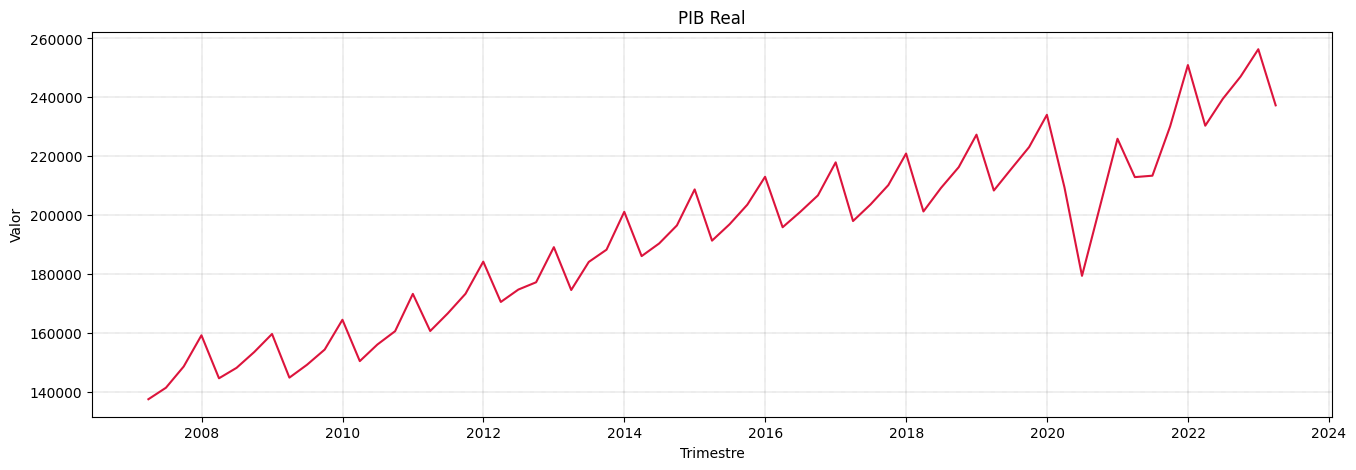

In [81]:
#Graficamos la serie de tiempo del PIB Real
plot_df(data, x=data.index, y=data["PIB_REAL"], title='PIB Real') 

Se observa como ha existido un crecimiento generalizado en el PIB Real de los ultimos años junto con lo que pareceria ser un componente tendencial y uno estacional, para este se tomo en cuenta desde el primero trimeste de 2007 hasta el primer trimestre de 2023.

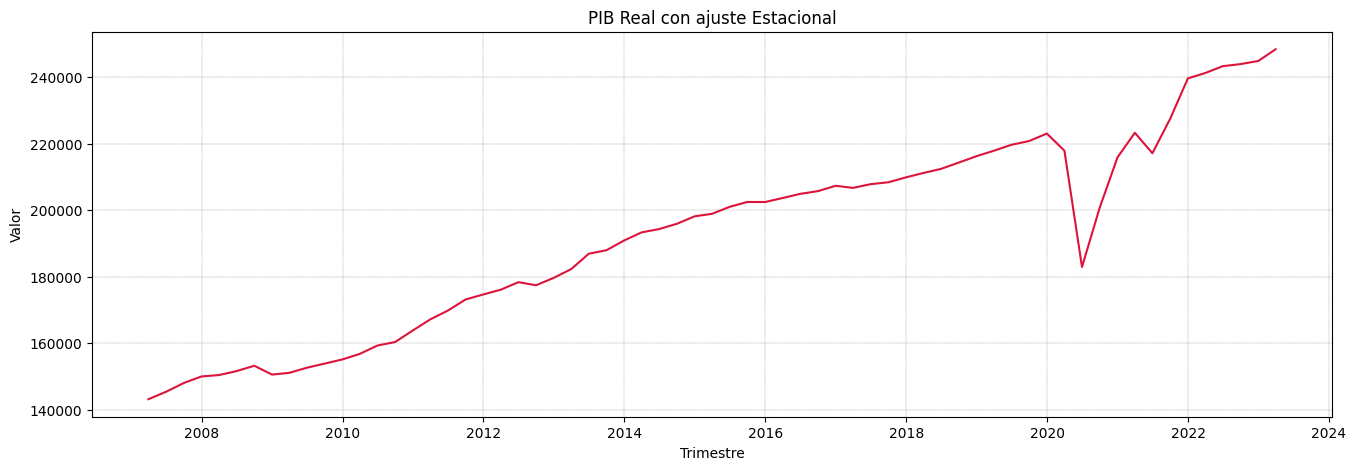

In [82]:
#Graficamos la serie de tiempo del PIB Real con ajuste Estacional
plot_df(data, x=data.index, y=data["PIB_REAL_EST"], title='PIB Real con ajuste Estacional') 

De la serie de tiempo con ajuste estacional realizado por el Banco de la República se observa como el componente estacional yo no se encuentra pero si se sigue observando el crecimiento generalizado de la serie de tiempo.

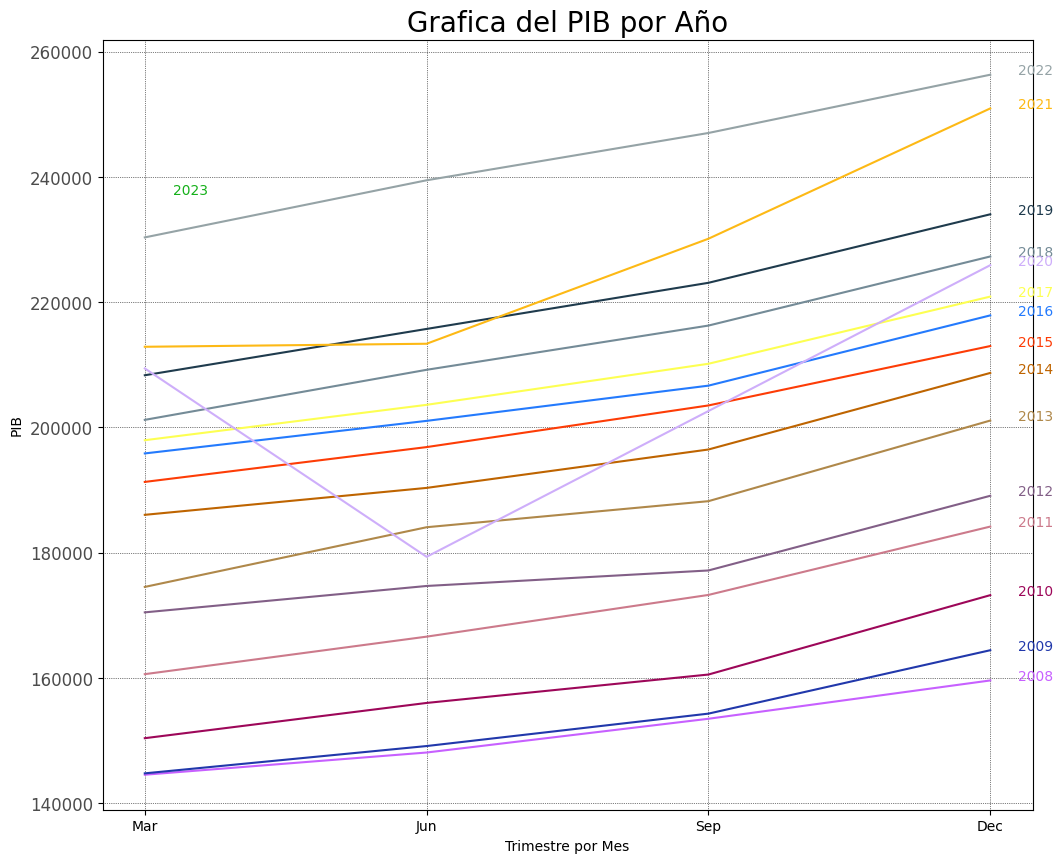

In [83]:
#Cargo los datos definiendo una variable nueva para no afectar los datos principales
ser2 = pd.read_excel('/content/gdrive/MyDrive/Maestria/Segundo Semestre/Proyecto Integrador/DATOS FINALES.xlsx', index_col=0)

#Preparo los datos separando por años y meses
ser2['year'] = [d.year for d in ser2.index]
ser2['month'] = [d.strftime('%b') for d in ser2.index]
years = ser2['year'].unique()

#Traigo los colores para cada grafica por año
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

#Grafico con un for para que las graficas se superpongan
plt.figure(figsize=(12,10), dpi= 100)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'PIB_REAL', data=ser2.loc[ser2.year==y, :], color=mycolors[i], label=y)
        plt.text(ser2.loc[ser2.year==y, :].shape[0]-.9, ser2.loc[ser2.year==y, 'PIB_REAL'][-1:].values[0], y, fontsize=10, color=mycolors[i])

plt.gca().set(ylabel='PIB', xlabel='Trimestre por Mes')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Grafica del PIB por Año", fontsize=20)
plt.grid(color="black",linestyle=':', linewidth=0.5)
plt.show()

Se observa como por timestre la mayoria de los años lleva un comportamiento similar pero con un valor mayor, correspondiendo a el aumento generalizado en el PIB Real, tambíen se observa dos años con un comportamiento que no sigue la tendencia y un cambio abrupto que son 2020 y 2021 años relacionados con la crisis económica causada por la pandemia Covid-19 y que en primera instancia podrian tratarse de Outliers.

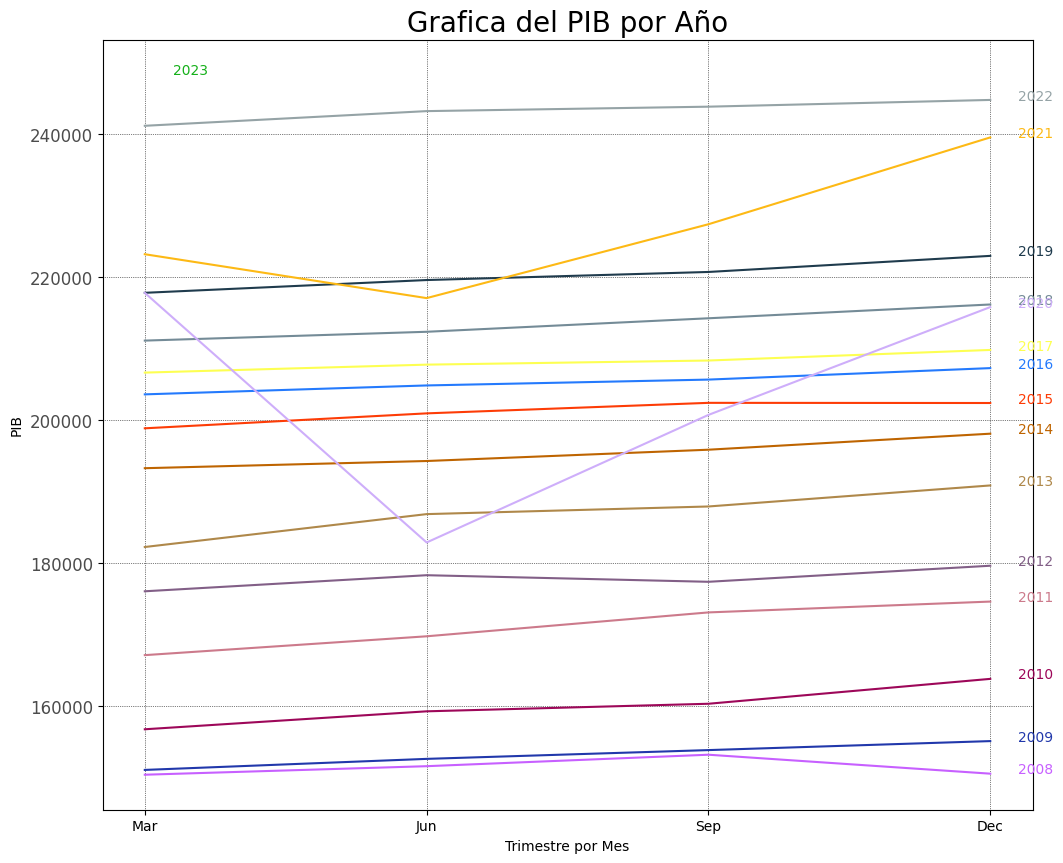

In [84]:
#Hago exactamente lo mismo con los datos del PIB Real con Ajuste estacional
ser2 = pd.read_excel('/content/gdrive/MyDrive/Maestria/Segundo Semestre/Proyecto Integrador/DATOS FINALES.xlsx', index_col=0)

#Preparo los datos separando por años y meses
ser2['year'] = [d.year for d in ser2.index]
ser2['month'] = [d.strftime('%b') for d in ser2.index]
years = ser2['year'].unique()

#Traigo los colores para cada grafica por año
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

#Grafico con un for para que las graficas se superpongan
plt.figure(figsize=(12,10), dpi= 100)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'PIB_REAL_EST', data=ser2.loc[ser2.year==y, :], color=mycolors[i], label=y)
        plt.text(ser2.loc[ser2.year==y, :].shape[0]-.9, ser2.loc[ser2.year==y, 'PIB_REAL_EST'][-1:].values[0], y, fontsize=10, color=mycolors[i])

plt.gca().set(ylabel='PIB', xlabel='Trimestre por Mes')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Grafica del PIB por Año", fontsize=20)
plt.grid(color="black",linestyle=':', linewidth=0.5)
plt.show()

Se observa el mismo comportamiento en el caso del PIB Real con ajuste estacional.

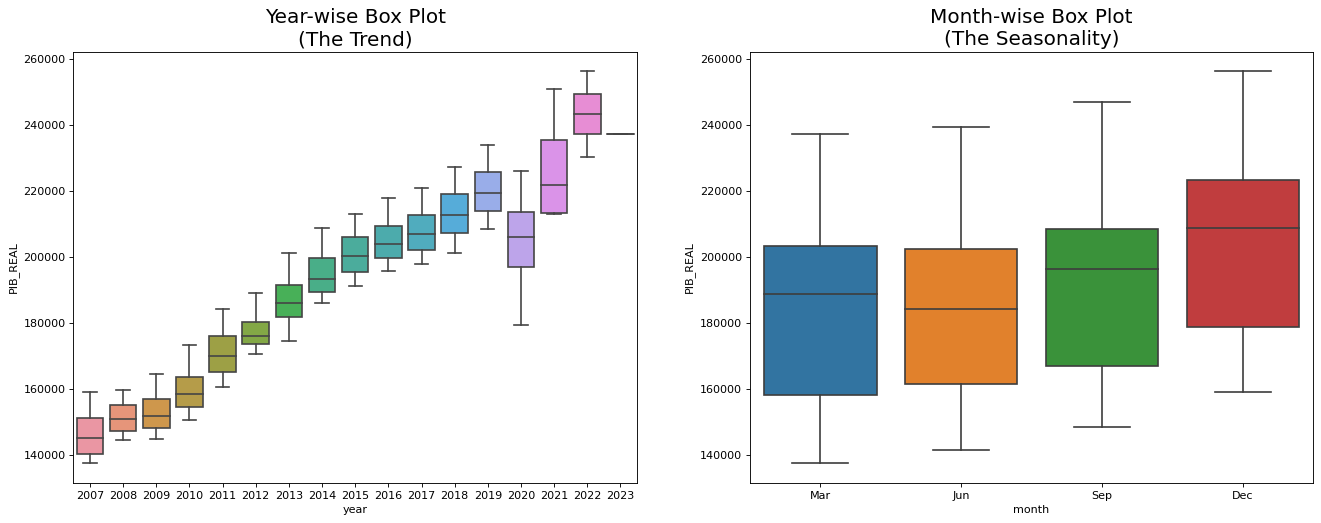

In [85]:
#Ahora busco graficar un Boxplot por año y por timestre para ver si se puede evidenciar alguna tendencia  u otro comportamiento en el PIB Real
#Creo la figura
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
#Boxplot para el año
sns.boxplot(x='year', y='PIB_REAL', data=ser2, ax=axes[0])
#Boxplot para el mes
sns.boxplot(x='month', y='PIB_REAL', data=ser2.loc[~ser2.year.isin([1986, 2019]), :])
#Isin me dice si el datose encuentra o no en el dataframe y me devulve un booleano, en este caso cuando agrego ~ me dice si efectivamente el dato no se encuentra en el dataframe

#Coloco los titulos
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

De la gráfica anual de los Box-Plots se observa de la misma manera que existe una tendencia alcista durante los años teniendo excluyendo el año de 2020 en el cual existio una externalidad, Covid-19,  que afecto en gran medida el PIB Real. De la gráfica de la parte derecha se observa como existe un componente  estacional sobre todo en los meses de Septiembre y DIciembre, al mismo tiempo se concluye que no hay outliers en la serie debido a que el mismo Box-Plot en ambos casos no los identifico.

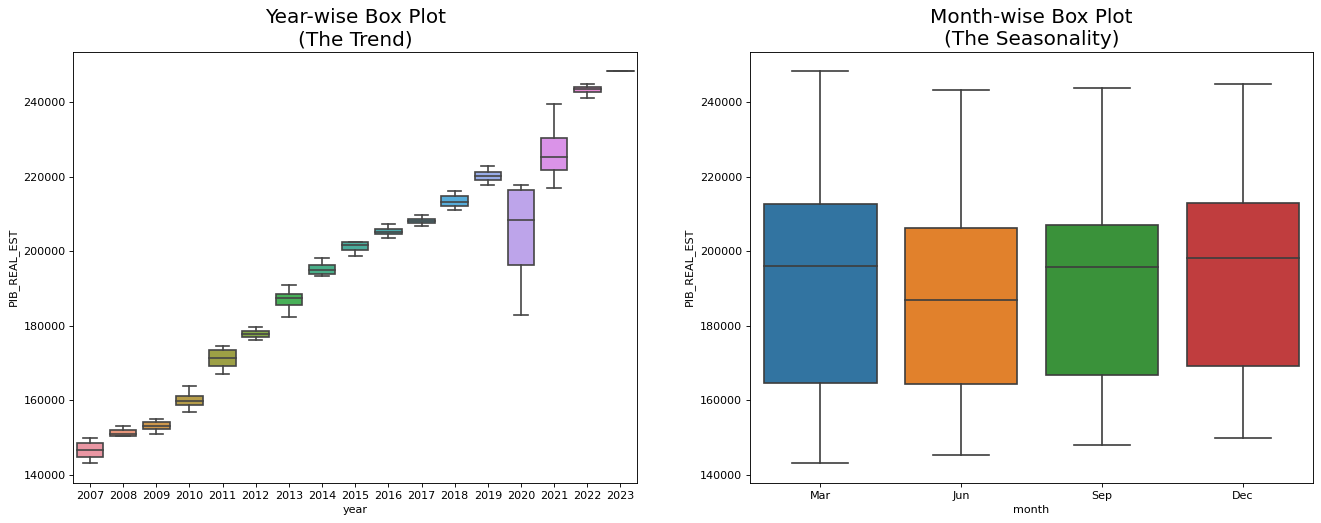

In [86]:
#Genero el mismo análisis para la serie de tiempo del PIB Real con Ajuste estacional

#Creo la figura
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
#Boxplot para el año
sns.boxplot(x='year', y='PIB_REAL_EST', data=ser2, ax=axes[0])
#Boxplot para el mes
sns.boxplot(x='month', y='PIB_REAL_EST', data=ser2.loc[~ser2.year.isin([1986, 2019]), :])
#Isin me dice si el datose encuentra o no en el dataframe y me devulve un booleano, en este caso cuando agrego ~ me dice si efectivamente el dato no se encuentra en el dataframe

#Coloco los titulos
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

De la primera gráfica se observa como el componente tendencial sigue estando latente pero el coomponente estacional no es tan notorio lo cual se debe al ajuste hecho por el Banco de la República.

# **Analisis de los componentes de la serie de tiempo**

In [87]:
#Los componentes de una serie de tiempo seran: El nivel de base, la tendencia, la estacionalidad y el error, podemos hacer la descomposición de una serie de tiempo como una combinación multiplicativa o aditiva
#El codigo de seasonal_decompose de la libreria de statsmodels nos sirve para esto
#Primero importo la libreria
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

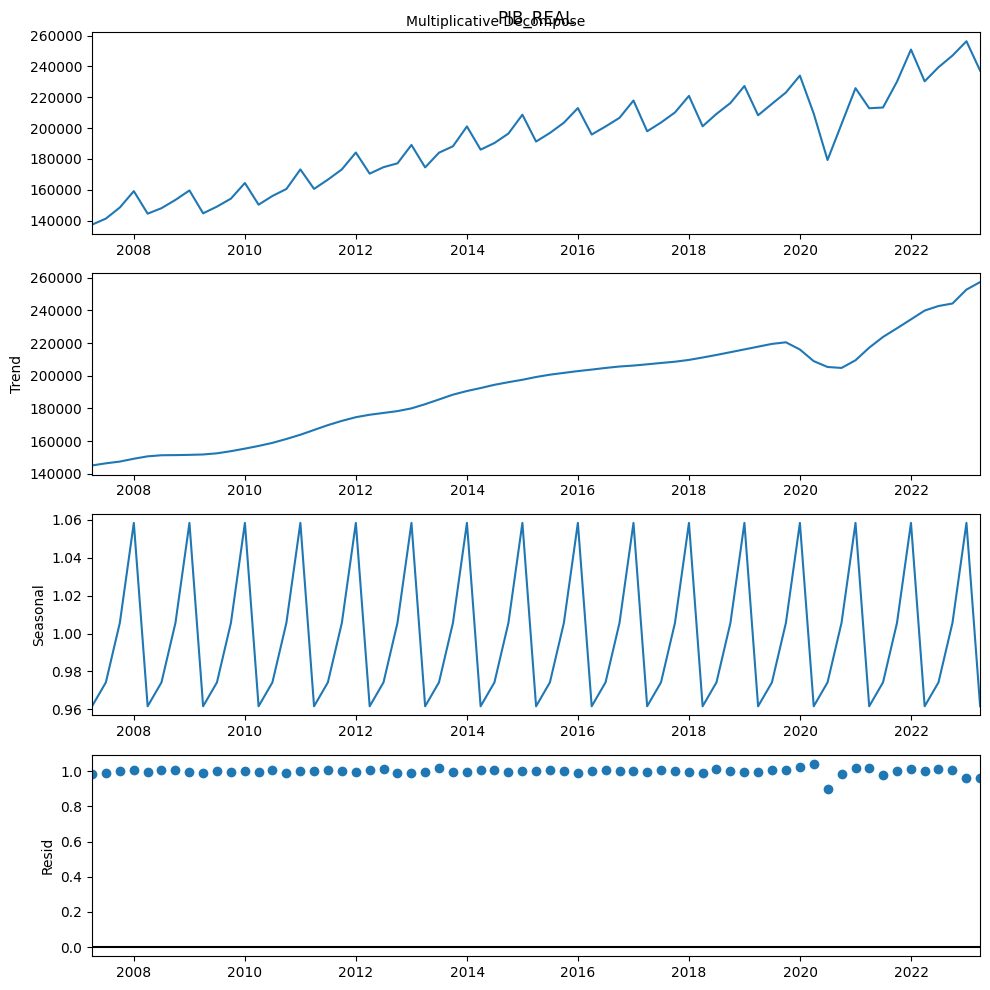

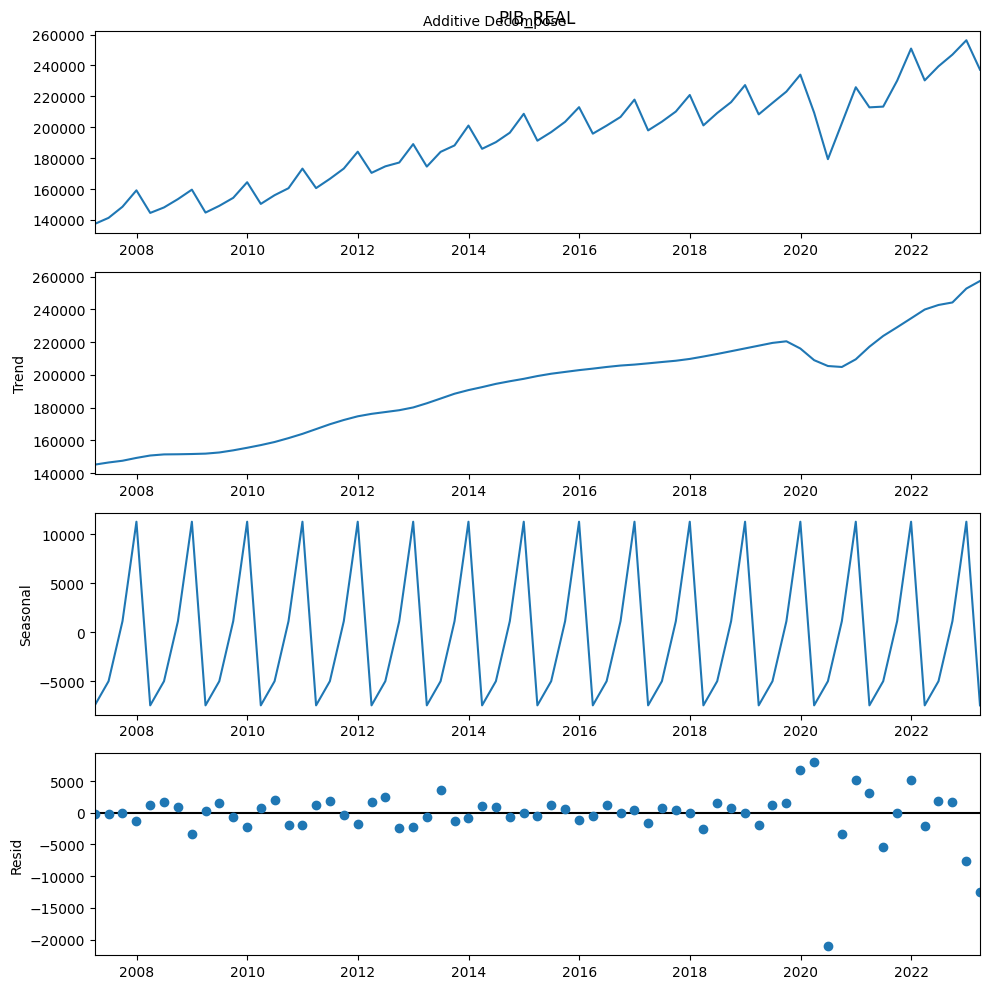

In [88]:
#Ahora lo que busco es observar la descomposición multiplicativa, siempre le tengo que especificar que tipo de descomposición quiero con la opción de modelo
#Empezaremos con la descomposición para el PIB Real sin ajuste
result_mul = seasonal_decompose(data['PIB_REAL'], model='multiplicative', extrapolate_trend='freq')

#Ahora obtengo la descompocisión aditiva
result_add = seasonal_decompose(data['PIB_REAL'], model='additive', extrapolate_trend='freq')

#Grafico las descomposiciones
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)
result_add.plot().suptitle('Additive Decompose', fontsize=10)
plt.show()

A primera instancia se evidencia que el componente tendencial de ambas descomposiciones es identico al igual que el componente estacional, del componente estacional se puede observar como en ambos casos existe un movimiento constante de este componente por lo que no se puede concluir que sea una serie multiplicativa, por ultimo del componente residual se observa como en ambas descomposiciones existe un patron aunque el aditivo contiene un componente más aleatorio sobre todo al final de la serie, por ende no se puede concluir al 100% que la serie siga una de estas dos descomposiciones aunque a primera instancia parece seguir una aditiva, es probable que tambien pueda ser una combinación de ambas.

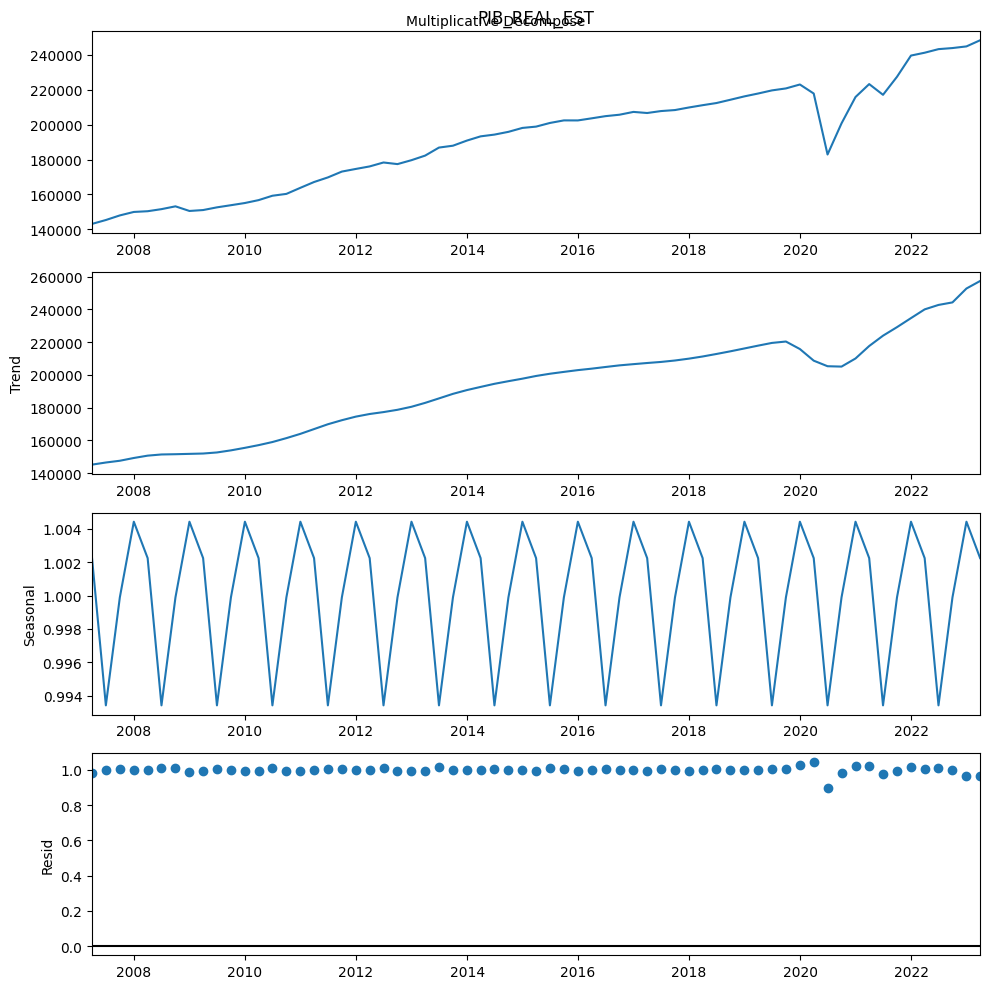

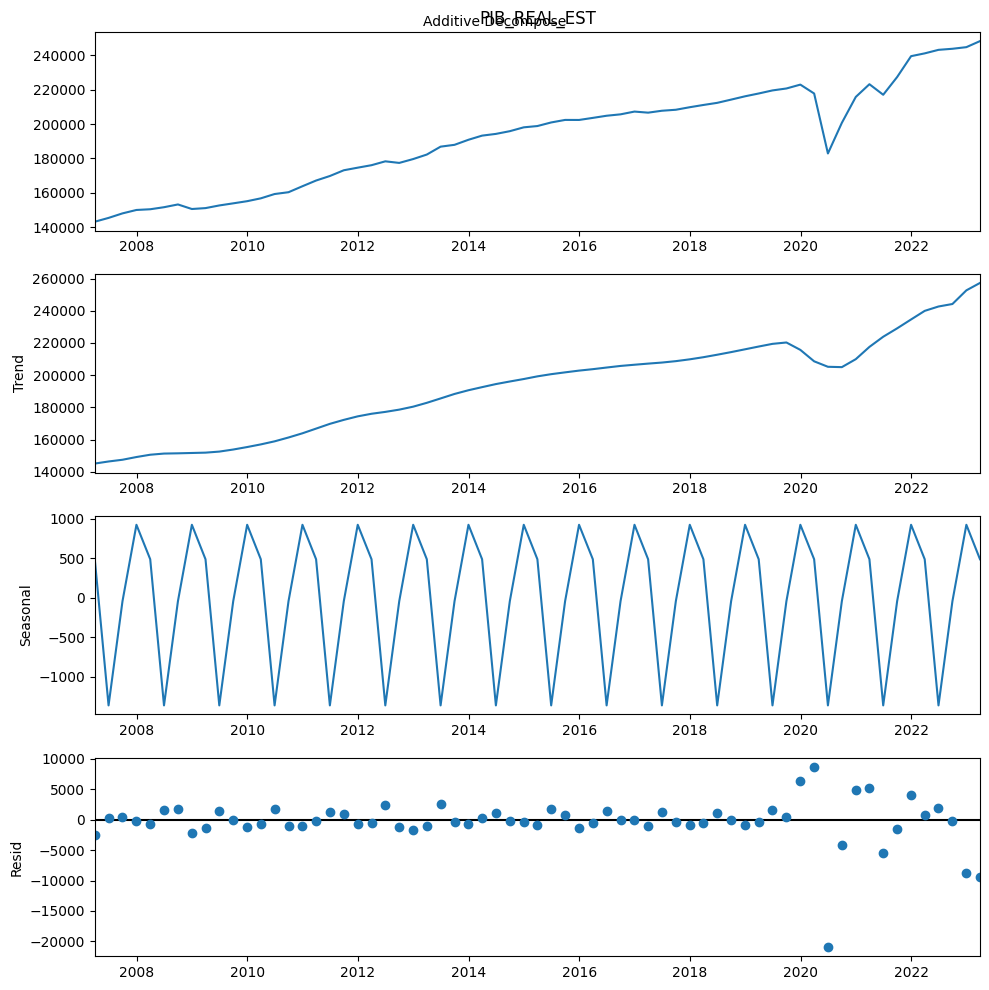

In [89]:
#Ahora hacemos el mismo ejercicio con la serie del PIB Real con Ajuste estacional

#Descompocisión multiplicativa
result_mul = seasonal_decompose(data['PIB_REAL_EST'], model='multiplicative', extrapolate_trend='freq')

#Descompocisión aditiva
result_add = seasonal_decompose(data['PIB_REAL_EST'], model='additive', extrapolate_trend='freq')

#Grafico las descomposiciones
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)
result_add.plot().suptitle('Additive Decompose', fontsize=10)
plt.show()

El PIB Real con ajuste estacional parece seguir la misma linea que el PIB Real en cuanto a la descomposición.

##**Análisi de la Estacionaridad**

In [90]:
#Primero corremos el test de Dickey Fuller para el PIB Real
result = adfuller(data["PIB_REAL"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

#Ahora el test de KPSS
result = kpss(data["PIB_REAL"].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.8068727255137331
p-value: 0.37705495422763335

KPSS Statistic: 1.348994
p-value: 0.010000


De los tests anteriores se puede concluir que la serie de tiempo no es estacionaria debido a que primero el test de Dickey Fuller no rechaza la hipotesis nula de que la serie es no estacionaria y segundo el KPSS sigue la linea del primer test concluyendo que la serie no es estacionaria, por ende esta sera una de las primeras intervenciones a la serie que se le deberan hacer.

In [91]:
#Hacemos lo mismo pero para el PIB Real con ajuste estacional
result = adfuller(data["PIB_REAL_EST"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

#KPSS
result = kpss(data["PIB_REAL_EST"].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -0.17710235832709562
p-value: 0.941196486732127

KPSS Statistic: 1.152335
p-value: 0.010000


Al igual que el anterior el PIB Real con Ajuste Estacional tampoco es estacionario según ambos test, con la particularidad de que tiene un peor P-Value que la serie de tiempo sin ajuste estacional.

## **Ajustando la serie para volverla estacionaria**


In [92]:
#Primero crearemos un DataFrame aleterno el cual solo contendra las variables del PIB Real.
data1 = data[["PIB_REAL", "PIB_REAL_EST"]]
data1.head()

,PIB_REAL,PIB_REAL_EST
FECHA,,
2007-03-31,137433.0679,143131.2067
2007-06-30,141334.6251,145354.9678
2007-09-30,148540.5141,147992.2543
2007-12-31,159148.7929,149978.5712
2008-03-31,144544.2263,150393.1367


In [93]:
#Saco las diferencias, logaritmos y raices para hacer estacionaria mi serie y quitar tendencias
data1['PIB(-1)'] = data1['PIB_REAL'].diff(periods=1)
data1['log_PIB'] = np.log(data['PIB_REAL'])
data1['log_PIB(-1)'] = data1['log_PIB'].diff(periods=1)
data1["raiz_PIB"] = np.sqrt(data["PIB_REAL"])
data1['raiz_PIB(-1)'] = data1['raiz_PIB'].diff(periods=1)
data1['PIB_EST(-1)'] = data1['PIB_REAL_EST'].diff(periods=1)
data1['log_PIB_EST'] = np.log(data['PIB_REAL_EST'])
data1['log_PIB_EST(-1)'] = data1['log_PIB_EST'].diff(periods=1)
data1["raiz_PIB_EST"] = np.sqrt(data["PIB_REAL_EST"])
data1['raiz_PIB_EST(-1)'] = data1['raiz_PIB_EST'].diff(periods=1)
data1.head()

,PIB_REAL,PIB_REAL_EST,PIB(-1),log_PIB,log_PIB(-1),raiz_PIB,raiz_PIB(-1),PIB_EST(-1),log_PIB_EST,log_PIB_EST(-1),raiz_PIB_EST,raiz_PIB_EST(-1)
FECHA,,,,,,,,,,,,
2007-03-31,137433.0679,143131.2067,NaN,11.830892,NaN,370.719662,NaN,NaN,11.871517,NaN,378.326852,NaN
2007-06-30,141334.6251,145354.9678,3901.5572,11.858886,0.027993,375.944976,5.225314,2223.7611,11.886934,0.015417,381.254466,2.927614
2007-09-30,148540.5141,147992.2543,7205.8890,11.908613,0.049727,385.409541,9.464565,2637.2865,11.904915,0.017981,384.697614,3.443148
2007-12-31,159148.7929,149978.5712,10608.2788,11.977595,0.068982,398.934572,13.525031,1986.3169,11.918248,0.013332,387.270669,2.573055
2008-03-31,144544.2263,150393.1367,-14604.5666,11.881341,-0.096254,380.189724,-18.744848,414.5655,11.921008,0.002760,387.805540,0.534871


In [94]:
#Ahora relleno el dato faltante de el primer NAN en las diferencias
data1['PIB(-1)'].iloc[0] = data1['PIB(-1)'].iloc[1:3].mean()
data1['log_PIB(-1)'].iloc[0] = data1['log_PIB(-1)'].iloc[1:3].mean()
data1['raiz_PIB(-1)'].iloc[0] = data1['raiz_PIB(-1)'].iloc[1:3].mean()
data1['PIB_EST(-1)'].iloc[0] = data1['PIB_EST(-1)'].iloc[1:3].mean()
data1['log_PIB_EST(-1)'].iloc[0] = data1['log_PIB_EST(-1)'].iloc[1:3].mean()
data1['raiz_PIB_EST(-1)'].iloc[0] = data1['raiz_PIB_EST(-1)'].iloc[1:3].mean()
data1.head()

,PIB_REAL,PIB_REAL_EST,PIB(-1),log_PIB,log_PIB(-1),raiz_PIB,raiz_PIB(-1),PIB_EST(-1),log_PIB_EST,log_PIB_EST(-1),raiz_PIB_EST,raiz_PIB_EST(-1)
FECHA,,,,,,,,,,,,
2007-03-31,137433.0679,143131.2067,5553.7231,11.830892,0.038860,370.719662,7.344939,2430.5238,11.871517,0.016699,378.326852,3.185381
2007-06-30,141334.6251,145354.9678,3901.5572,11.858886,0.027993,375.944976,5.225314,2223.7611,11.886934,0.015417,381.254466,2.927614
2007-09-30,148540.5141,147992.2543,7205.8890,11.908613,0.049727,385.409541,9.464565,2637.2865,11.904915,0.017981,384.697614,3.443148
2007-12-31,159148.7929,149978.5712,10608.2788,11.977595,0.068982,398.934572,13.525031,1986.3169,11.918248,0.013332,387.270669,2.573055
2008-03-31,144544.2263,150393.1367,-14604.5666,11.881341,-0.096254,380.189724,-18.744848,414.5655,11.921008,0.002760,387.805540,0.534871


In [95]:
#Ahora vuelvo a sacar los test de estacionariedad para ver si los diferentes ajustes a los datos funcionaron

#Hacemos lo mismo pero para el PIB Real con ajuste estacional

print("Análisis para el PIB Real con Ajuste Estacional")

print("                                                               ")

print("Análisis para una diferencia")

result = adfuller(data1["PIB(-1)"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

result = kpss(data1["PIB(-1)"].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print("-----------------------------------------------------------------------")

print("Análisis para la diferencia del logaritmo")

result = adfuller(data1["log_PIB(-1)"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

result = kpss(data1["raiz_PIB(-1)"].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print("Análisis para el PIB Real con Ajuste Estacional")

print("-----------------------------------------------------------------------")

print("Análisis para una diferencia")

result = adfuller(data1["PIB_EST(-1)"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

result = kpss(data1["PIB_EST(-1)"].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print("-----------------------------------------------------------------------")

print("Análisis para la diferencia del logaritmo")

result = adfuller(data1["log_PIB_EST(-1)"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

result = kpss(data1["log_PIB_EST(-1)"].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

Análisis para el PIB Real con Ajuste Estacional
                                                               
Análisis para una diferencia
ADF Statistic: -2.6201240724210884
p-value: 0.08890894941729538

KPSS Statistic: 0.180900
p-value: 0.100000
-----------------------------------------------------------------------
Análisis para la diferencia del logaritmo
ADF Statistic: -2.5226308029754874
p-value: 0.11006465035935897

KPSS Statistic: 0.234055
p-value: 0.100000
Análisis para el PIB Real con Ajuste Estacional
-----------------------------------------------------------------------
Análisis para una diferencia
ADF Statistic: -7.556424233183984
p-value: 3.0908669371372585e-11

KPSS Statistic: 0.092937
p-value: 0.100000
-----------------------------------------------------------------------
Análisis para la diferencia del logaritmo
ADF Statistic: -7.530676147765089
p-value: 3.58555834534179e-11

KPSS Statistic: 0.108138
p-value: 0.100000


## **Análisis de las Autocorrelaciones parciales y Lags** 

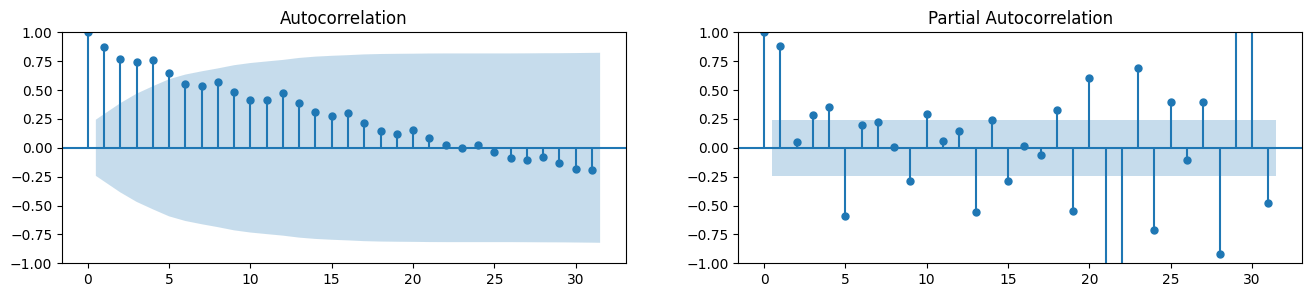

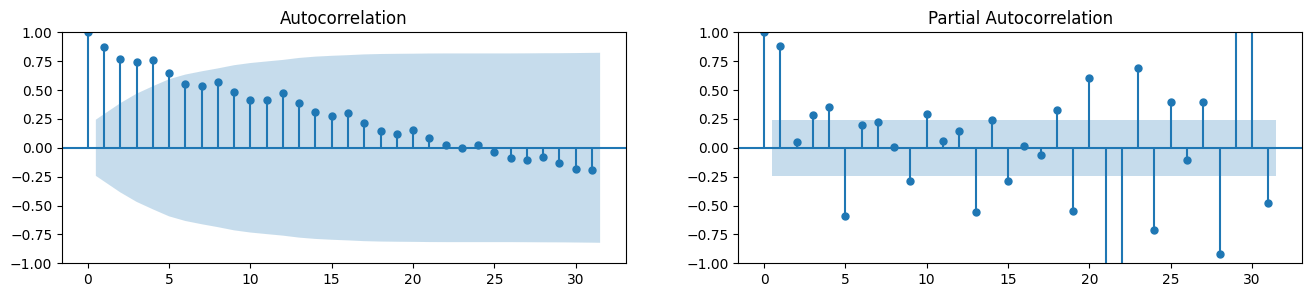

In [96]:
#Ahora busco calcular las autocorrelaciones parciales 

#Importo las librerias
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Calculo la autocorrelación y la autocorrelación parcial hasta 50 lags
#acf_50 = acf(ser.AAPL.value, nlags=50)
#pacf_50 = pacf(ser.AAPL.value, nlags=50)

#Grafico
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data["PIB_REAL"].tolist(), lags=31, ax=axes[0])
plot_pacf(data["PIB_REAL"].tolist(), lags=31, ax=axes[1])

Se observa como existen varios resagos que son significativos teniendo en cuenta la autocorrelación parcial, pero no se observa un decrecimiento constante en la significancia de los resagos ya que los resagos 21 y 22 al igual que 29 y 30 tienen una fuerte autocorrelación parcial mientras que solo los 4 primeros tienen una autocorrelación con significancia.

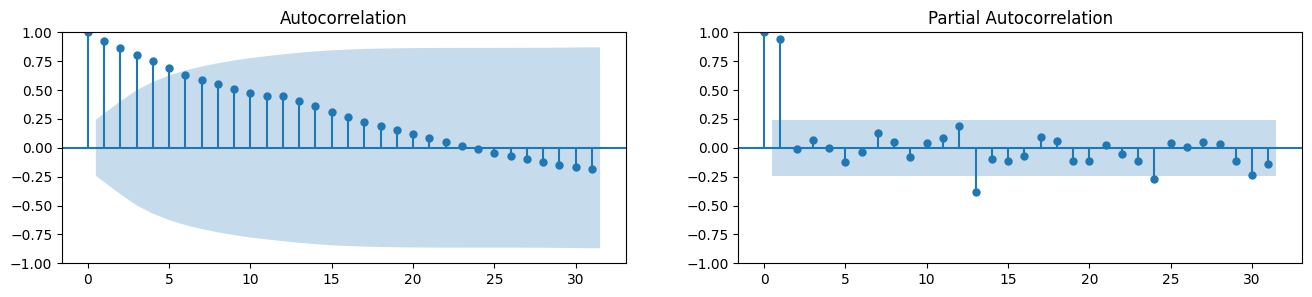

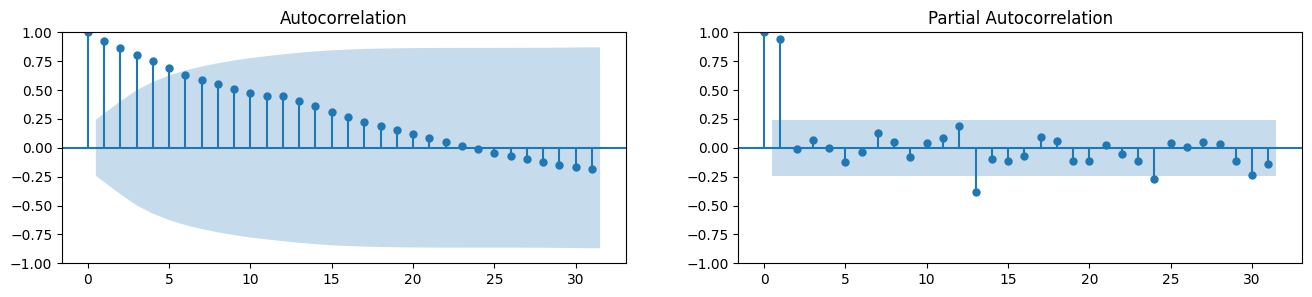

In [97]:
#Ahora para la serie con ajuste estacional

#Importo las librerias
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Calculo la autocorrelación y la autocorrelación parcial hasta 50 lags
#acf_50 = acf(ser.AAPL.value, nlags=50)
#pacf_50 = pacf(ser.AAPL.value, nlags=50)

#Grafico
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data["PIB_REAL_EST"].tolist(), lags=31, ax=axes[0])
plot_pacf(data["PIB_REAL_EST"].tolist(), lags=31, ax=axes[1])

Por su lado usando el PIB Real con ajuste estacional se observa claramente en la grafica de la autocorrelación parcial como los dos primeros resagos son los que mayor significancia tienen mientras la autocorrelación nos indica que por lo menos los 4 primeros resagos tienen una fuerte autocorrelación. 

# **Modelo AR(2) y AR(4)**

De acuerdo a lo anterior se decide usar dos tipos de modelos AR el primero con dos resagos y el segundo con 4 y revisar sus errores.

In [98]:
#Importo las librerias necesarias 
import statsmodels as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA

In [129]:
#Dividimos el Dataset en uno el cual nos permita calcular el último dato y despues los ultimos 8
Ntest = 12

train = data1.iloc[:-Ntest]
test = data1.iloc[-Ntest:]

train_idx = data1.index <= train.index[-1]
test_idx = data1.index > train.index[-1]

In [134]:
#Primero con el modelo AR(2)
arima21 = ARIMA(train['PIB_EST(-1)'], order =(2,0,0))
#Saco los resultados del modelo
arima_result21 = arima21.fit()
#Llevo los datos obtenidos de entrenamiento a el dataframe que estoy trabajando
data1.loc[train_idx, 'AR(2)'] = arima_result21.predict(start = train.index[0], end= train.index[-1])

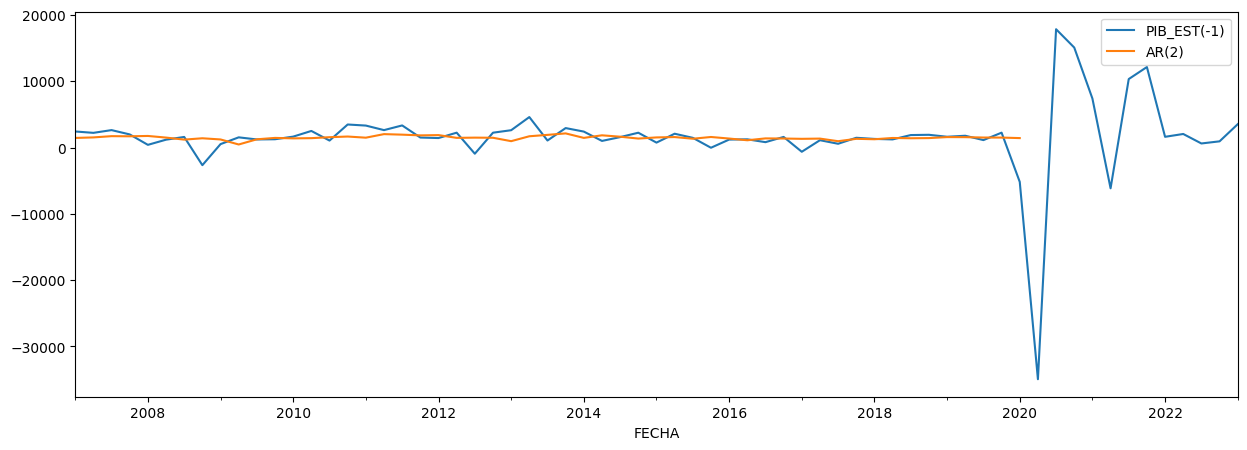

In [135]:
#Observo como quedaron mis datos entrenados por el modelo ARIMA con los datos reales de la Acción de Apple, al parecer va bien
data1[['PIB_EST(-1)', 'AR(2)']].plot(figsize= (15,5));

In [138]:
#Codigo para la prediccion
prediction_result21 = arima_result21.get_forecast(Ntest)
forecast21 = prediction_result21.predicted_mean
data1.loc[test_idx, 'AR(2)']= forecast21

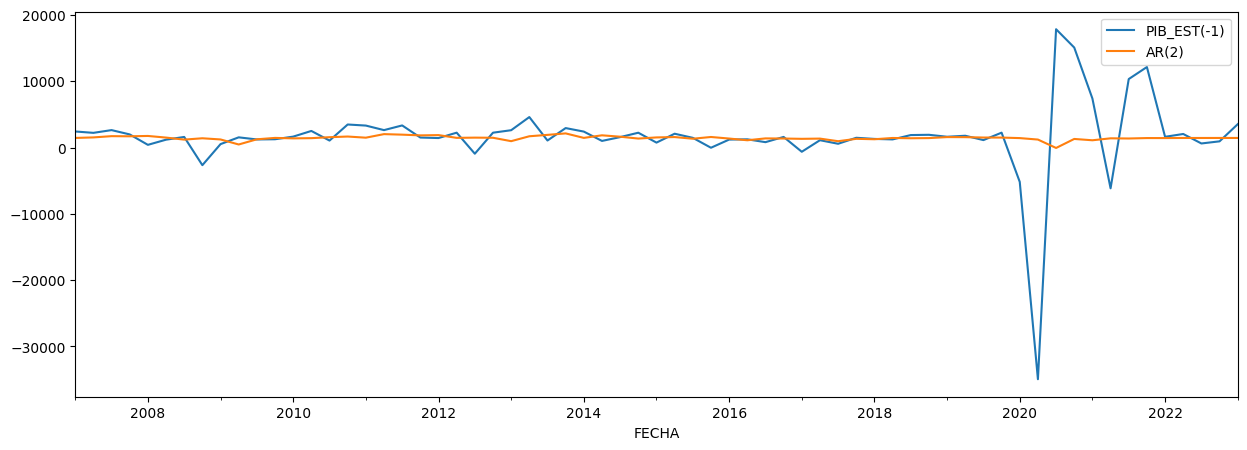

In [139]:
#Grafico nuevamente mis resultados con los datos de predicción que me arroja el dataset de testeo
data1[['PIB_EST(-1)', 'AR(2)']].plot(figsize = (15,5));

In [104]:
#Ahora busco graficar los datos de predicción y tambien el rango de la predicción
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize = (15,5))
    ax.plot(data['PIB_EST(-1)'], label = 'data')
    
    #plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color = 'green', label = 'fitted')
    
    #forecast the test set
    
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower PIB_EST(-1)'], conf_int['upper PIB_EST(-1)']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label = 'Forecast')
    ax.fill_between(test.index, \
                   lower, upper,\
                   color = 'red', alpha = 0.3)
    
    ax.legend()

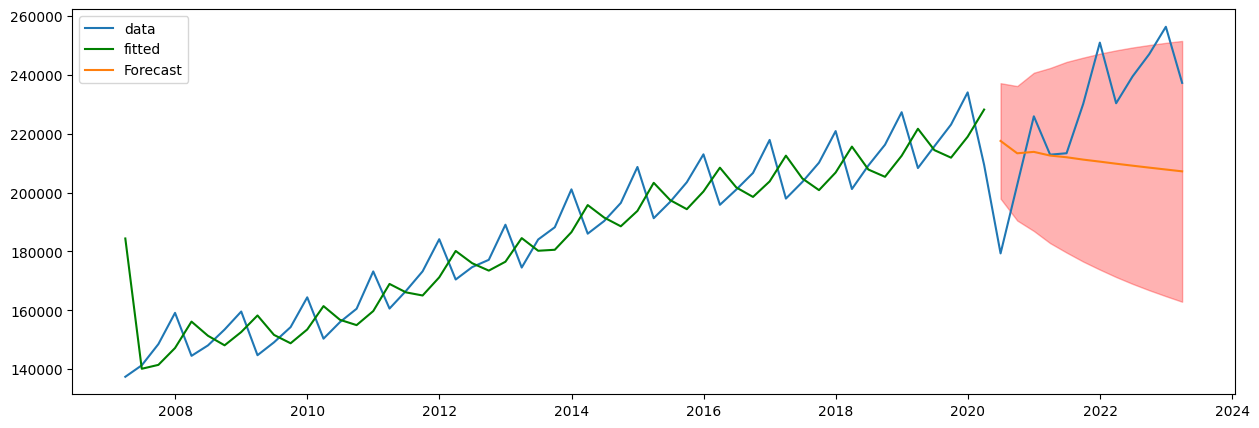

In [105]:
plot_fit_and_forecast(arima_result21)

In [140]:
#Ahora con el AR(4)
arima24 = ARIMA(train['PIB_EST(-1)'], order =(4,0,0))
#Saco los resultados del modelo
arima_result24 = arima24.fit()
#Llevo los datos obtenidos de entrenamiento a el dataframe que estoy trabajando
data1.loc[train_idx, 'AR(4)'] = arima_result24.predict(start = train.index[0], end= train.index[-1])

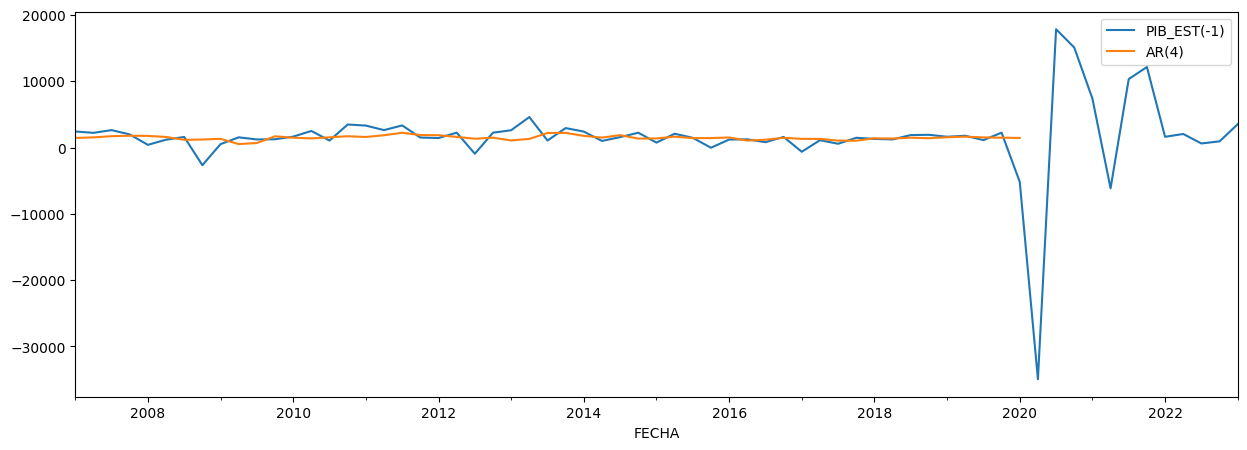

In [141]:
data1[['PIB_EST(-1)', 'AR(4)']].plot(figsize= (15,5));

In [142]:
prediction_result24 = arima_result24.get_forecast(Ntest)
forecast24 = prediction_result24.predicted_mean
data1.loc[test_idx, 'AR(4)']= forecast24

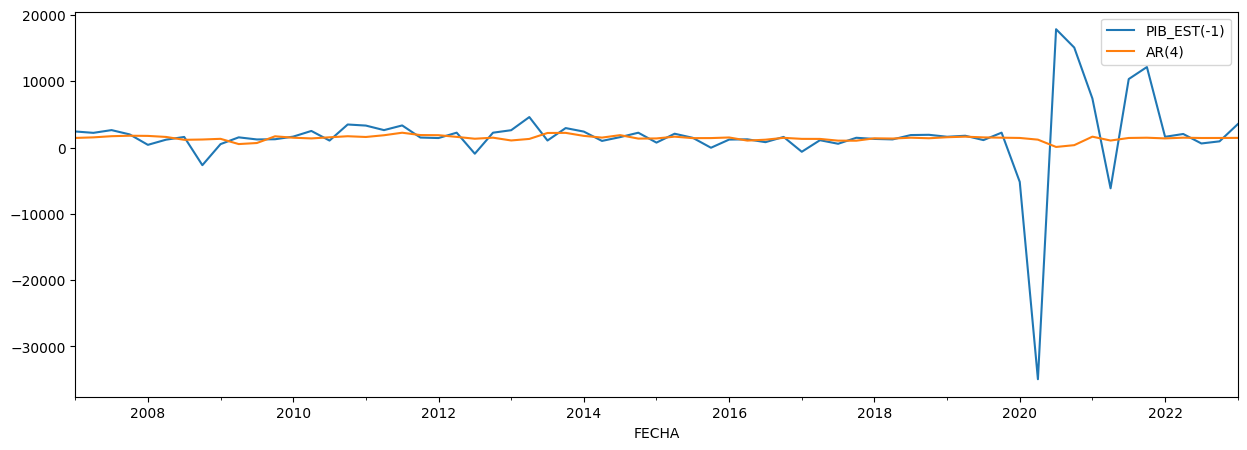

In [144]:
data1[['PIB_EST(-1)', 'AR(4)']].plot(figsize = (15,5));

KeyError: ignored

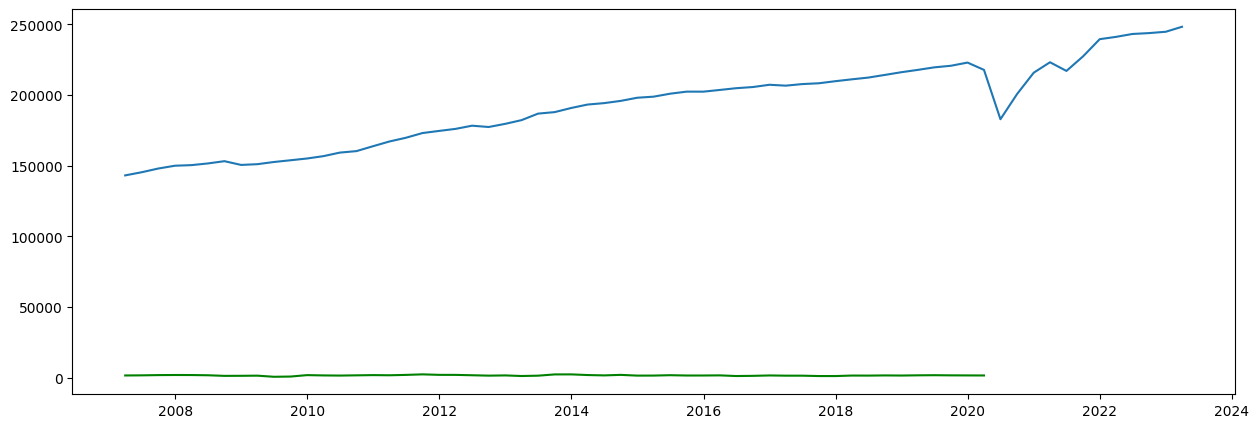

In [145]:
plot_fit_and_forecast(arima_result24)

##Ahora con el PIB Real con Ajuste estacionario

In [111]:
#Primero con el modelo AR(2)
arima2 = ARIMA(train['PIB_REAL_EST'], order =(2,0,0))
#Saco los resultados del modelo
arima_result2 = arima2.fit()
#Llevo los datos obtenidos de entrenamiento a el dataframe que estoy trabajando
data.loc[train_idx, 'AR_EST(2)'] = arima_result2.predict(start = train.index[0], end= train.index[-1])

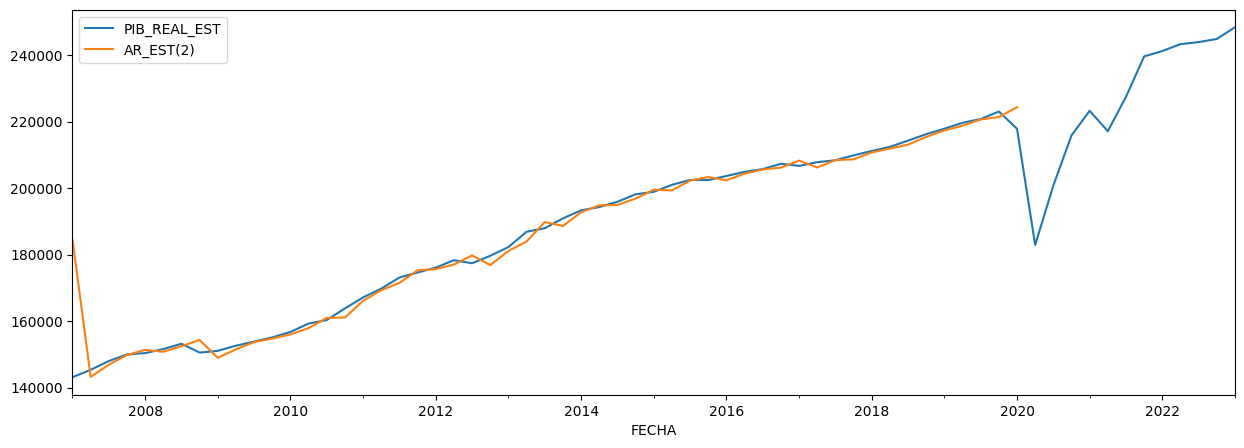

In [112]:
#Observo como quedaron mis datos entrenados por el modelo ARIMA con los datos reales de la Acción de Apple, al parecer va bien
data[['PIB_REAL_EST', 'AR_EST(2)']].plot(figsize= (15,5));

In [113]:
#Codigo para la prediccion
prediction_result2 = arima_result2.get_forecast(Ntest)
forecast2 = prediction_result2.predicted_mean
data.loc[test_idx, 'AR_EST(2)']= forecast2

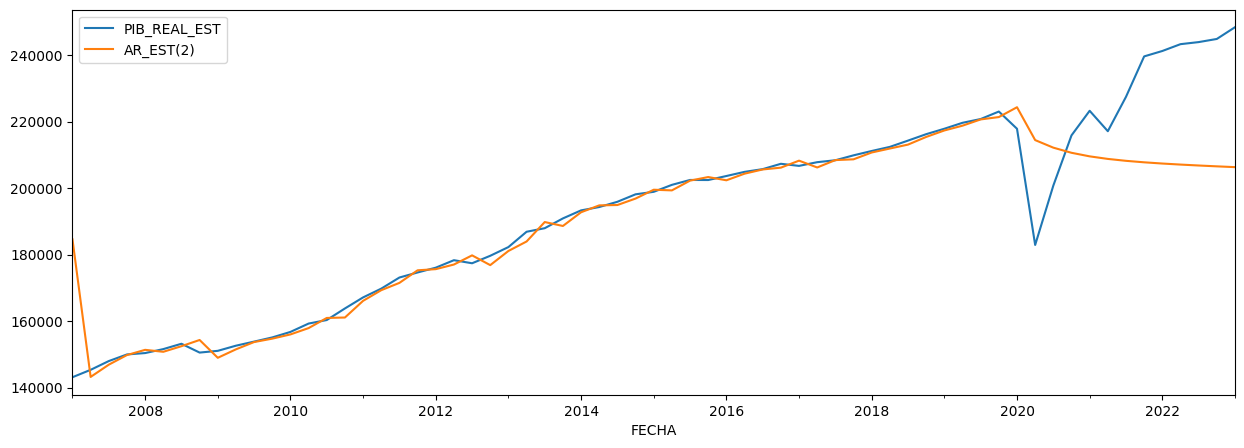

In [114]:
#Grafico nuevamente mis resultados con los datos de predicción que me arroja el dataset de testeo
data[['PIB_REAL_EST', 'AR_EST(2)']].plot(figsize = (15,5));

In [115]:
#Ahora busco graficar los datos de predicción y tambien el rango de la predicción
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize = (15,5))
    ax.plot(data['PIB_REAL_EST'], label = 'data')
    
    #plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color = 'green', label = 'fitted')
    
    #forecast the test set
    
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower PIB_REAL_EST'], conf_int['upper PIB_REAL_EST']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label = 'Forecast')
    ax.fill_between(test.index, \
                   lower, upper,\
                   color = 'red', alpha = 0.3)
    
    ax.legend()

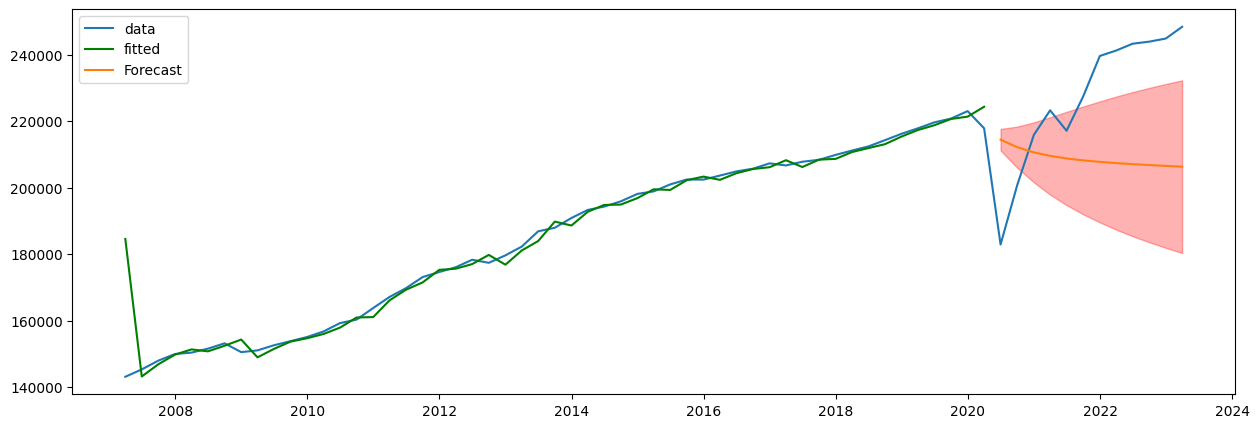

In [116]:
plot_fit_and_forecast(arima_result2)

In [117]:
#Primero con el modelo AR(4)
arima24 = ARIMA(train['PIB_REAL_EST'], order =(4,0,0))
#Saco los resultados del modelo
arima_result24 = arima24.fit()
#Llevo los datos obtenidos de entrenamiento a el dataframe que estoy trabajando
data.loc[train_idx, 'AR_EST(4)'] = arima_result24.predict(start = train.index[0], end= train.index[-1])

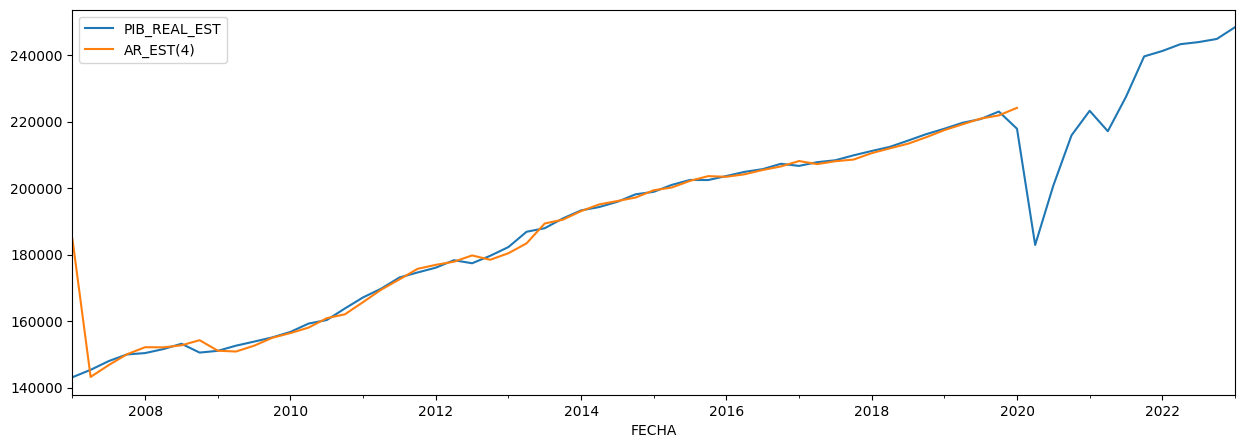

In [118]:
#Observo como quedaron mis datos entrenados por el modelo ARIMA con los datos reales de la Acción de Apple, al parecer va bien
data[['PIB_REAL_EST', 'AR_EST(4)']].plot(figsize= (15,5));

In [119]:
#Codigo para la prediccion
prediction_result24 = arima_result24.get_forecast(Ntest)
forecast24 = prediction_result24.predicted_mean
data.loc[test_idx, 'AR_EST(4)']= forecast24

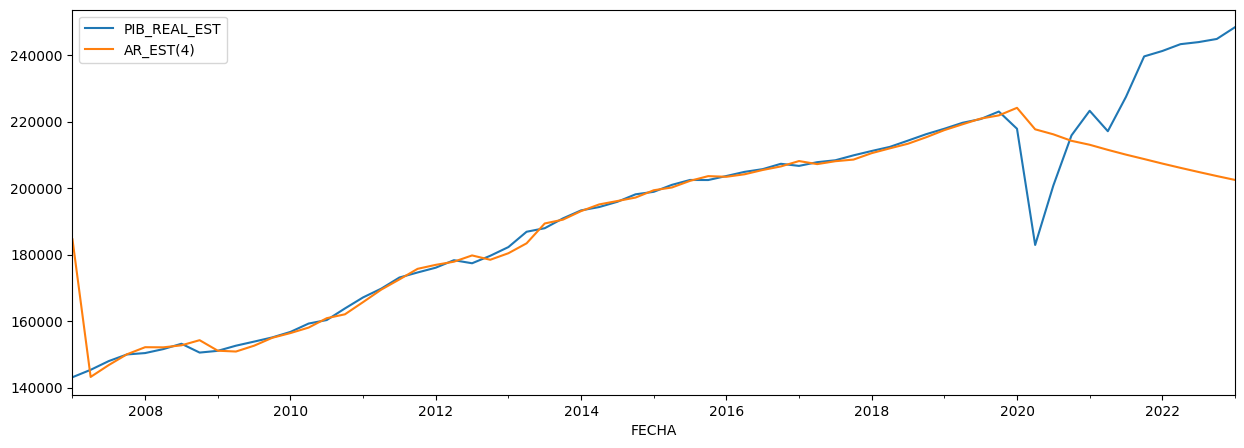

In [120]:
#Grafico nuevamente mis resultados con los datos de predicción que me arroja el dataset de testeo
data[['PIB_REAL_EST', 'AR_EST(4)']].plot(figsize = (15,5));

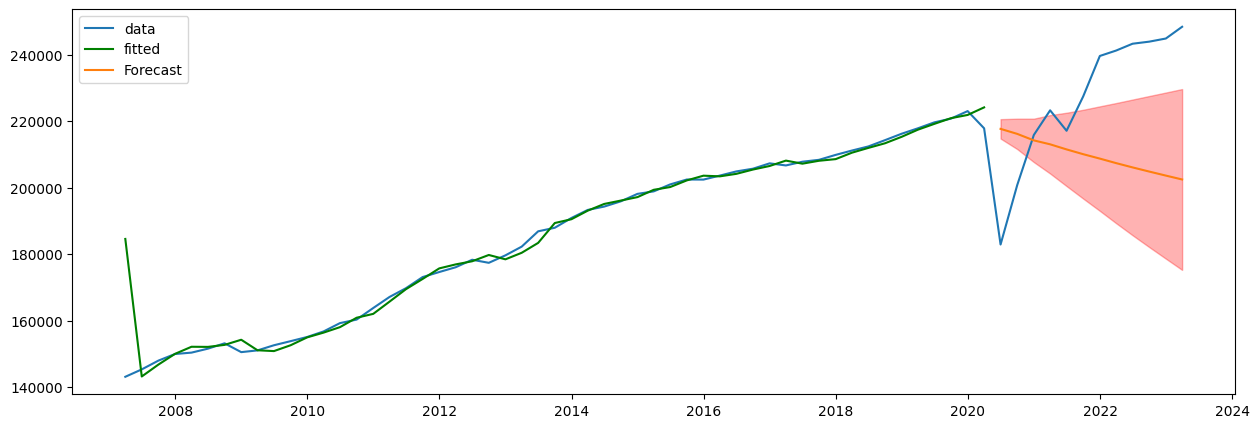

In [121]:
plot_fit_and_forecast(arima_result24)

In [127]:
# Calculamos el MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['PIB_REAL_EST'], data['AR_EST(2)'][53:65])
print(f"MSE: {mse: }")

MSE:  821754931.775083


##Modelo ARX

In [126]:
!pip install gekko
from gekko import GEKKO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 22.3 MB/s eta 0:00:00


In [ ]:
na = 4
nb = 3
ny = 8 
nu = 56

